# X-GAN

### 引入库函数

In [1]:

import numpy as np
import os
import cv2
import math

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt


### 将图像转化为矩阵并返回

In [2]:
def readimage(image):
    A = Image.open(image).convert('L')
    B = Image.open(image)
    a = np.array(A)
    b = np.array(B)
    return a,b

### rgb2grey

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### 将矩阵转化为图像

In [4]:
def MatrixToImage(R,G,B):
    # 得到RGB通道
    r = Image.fromarray(R).convert('L')
    g = Image.fromarray(G).convert('L')
    b = Image.fromarray(B).convert('L')
    image = Image.merge("RGB", (r, g, b))
    return image  

### 图像显示

In [5]:
def show(img):
    plt.figure("Image") # 图像窗口名称
    plt.imshow(img)
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image') # 图像题目
    plt.show() 

### 卷积

In [6]:
def convolve(image, weight):
    height, width = image.shape
    h, w = weight.shape
    height_new = height - h + 1
    width_new = width - w + 1
    image_new = np.zeros((height_new, width_new), dtype=np.float)
    for i in range(height_new):
        for j in range(width_new):
            image_new[i,j] = np.sum(image[i:i+h, j:j+w] * weight)
    image_new = image_new.clip(0,255)
    #image_new = np.rint(image_new).astype('uint8')
    return image_new

### Sobel-RGB

In [7]:
def sobel(image,name):
     
    a=readimage(image)
    print(a.shape)
    
    soble_x = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
    soble_y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
     
    #在三个通道上做水平方向上的卷积
    
    R0 = convolve(a[:, :, 0], soble_x)
    G0 = convolve(a[:, :, 1], soble_x)
    B0 = convolve(a[:, :, 2], soble_x)
    
    #在三个通道上做垂直方向上的卷积
    R1 = convolve(a[:, :, 0], soble_y)
    G1 = convolve(a[:, :, 1], soble_y)
    B1 = convolve(a[:, :, 2], soble_y)
    
    #综合水平方向和垂直方向上的信息
    Rx=R0*R0+R1*R1
    Gx=G0*G0+G1*G1
    Bx=B0*B0+B1*B1
    print(f'the max value of the gradients {np.max(Rx)}')
    print(f'the min value of the gradients {np.min(Rx)}')
    #做开方处理，为方便下面对于Canny第二步的处理
    l=Rx.shape[0]
    w=Rx.shape[1]
    R=np.zeros([l,w],float)
    G=np.zeros([l,w],float)
    B=np.zeros([l,w],float)
    
    theR=np.zeros([l,w],float)
    theG=np.zeros([l,w],float)
    theB=np.zeros([l,w],float)
    
    for i in range(l):
        for j in range(w):
            R[i,j]=np.rint((math.sqrt(Rx[i,j]))).astype('uint8')
            G[i,j]=np.rint((math.sqrt(Gx[i,j]))).astype('uint8')
            B[i,j]=np.rint((math.sqrt(Bx[i,j]))).astype('uint8')
            
            theR[i,j]=math.atan2(R0[i,j],R1[i,j])*180/math.pi
            theG[i,j]=math.atan2(G0[i,j],G1[i,j])*180/math.pi
            theB[i,j]=math.atan2(B0[i,j],B1[i,j])*180/math.pi
    
    img=MatrixToImage(R,G,B)
    gradients = MatrixToImage(Rx,Gx,Bx)
    show(img)
    show(gradients)
    img.save('./'+name+'sobel.png','png')
    img = np.array(img)
    return img,gradients


### Sobel-Grey

In [8]:
def grey_sobel(image,name):
     
    a = image
    
    soble_x = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
    soble_y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
     
    #在三个通道上做水平方向上的卷积
    
    x = convolve(a,soble_x)
    
    #在三个通道上做垂直方向上的卷积
    y = convolve(a,soble_y)
    
    #综合水平方向和垂直方向上的信息
    gradients=np.sqrt(x*x+y*y)

    return gradients


### image-crop

In [9]:
def img_crop(path):
    img=Image.open(path)
    box=(1,1,249,249)
    roi=img.crop(box)
    roi=np.array(roi)
    return roi[:, :, 0:3]
#     print(roi.shape)

### Sigmoid

In [10]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

### Choose Pixels

In [20]:
import numpy.ma as ma

def choose(img,probability,num):
    count = 0
    total = img.size
    rate = num /total
    print(f'rate {rate}')
    channel = img.shape[2]
    proba = probability.reshape(-1)
    number = int(np.ceil(rate * probability.size))
    print(f'number {number}')
    value = np.sort(-proba)
    print(value)
    value = -value[number]
    print(f'threshold {value}')
    threshold = np.full_like(probability,value)
    mask = probability > threshold
#     print(f'the number of the mask {mask}')
    out = img[:,:,0:3]
#     print(f'the shape of the img {img.shape}')
#     print(f'the shape of the probability  {probability.shape}')
        
    out[:,:,0] = mask * img[:,:,0]
    out[:,:,1] = mask * img[:,:,1]
    out[:,:,2] = mask * img[:,:,2]
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for k in range(out.shape[2]):
                if out[i,j,k]==0:
                    out[i,j,k]=255
    print(out.shape)
    return out


### padding 

In [13]:

def padding(img,mode='rgb'):
    if mode == 'rgb':
        padX= np.pad(img,((1,1),(1,1),(0,0)),'edge',)
    elif mode =='grey':
        padX= np.pad(img,((1,1),(1,1)),'edge',)
    else:
        print('ERROR MODE')
    return padX


### Main

rate 0.06570647603027754
number 12500
[-360.62445841 -360.62445841 -360.62445841 ...   -0.           -0.
   -0.        ]
threshold 159.9624956044385
(328, 580, 3)


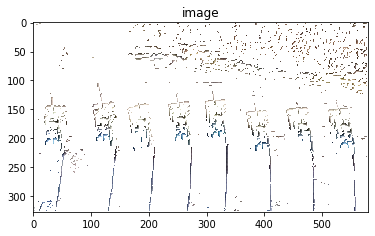

In [25]:

if __name__ == "__main__":
    image='1.png'
    grey,rgb =  readimage(image)
    grey = padding(grey,mode='grey')
    gradients = grey_sobel(grey,'sobel') 
#     probability = sigmoid(gradients)
    pic = choose(rgb,gradients,50000)
    pic = MatrixToImage(pic[:, :, 0],pic[:, :, 1],pic[:, :, 2])
    show(pic)
    pic.save('./choose.png','png')

### 查看颜色

In [ ]:
from PIL import ImageColor
print(ImageColor.getcolor('red', 'RGBA'))
# 也可以只以RBG的方式查看
print(ImageColor.getcolor('white', 'RGB'))